In [79]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transformst
import torchvision.transforms as transforms

In [80]:
# Set default tensor type to CUDA if available
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU...")
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

## Implementación de la clasiﬁcación multiclase de imágenes con Bayes ingenuo usando histogramas

Para el presente ejercicio, se implementará la clasiﬁcación de imagenes
naturales con K = 10 clases. La Figura 1 muestra algunas observaciones
del conjunto de datos. El objetivo de su equipo de desarrollo es utili-
zar el teorema de Bayes para construir un modelo conocido como Bayes
ingenuo, el cual permita estimar la clase a la que pertenece una nueva
observación



In [81]:
def load_cifar10_dataset(is_train=True):
  # Define a transformation to convert images to grayscale
  transforms_1 = transforms.Compose([
      transforms.ToTensor(),
      transforms.Grayscale(num_output_channels=1)  # Convert to grayscale
  ])
  cifar_trainset = datasets.CIFAR10(
      root='./data', train=is_train, download=True, transform=transforms_1)

  # Initialize an empty list to store batches
  all_data = []
  train_loader = torch.utils.data.DataLoader(
      cifar_trainset, batch_size=64, shuffle=True)
  # Iterate over the train_loader to fetch all batches
  for batch in train_loader:
      images, _ = batch  # Extract images from the batch
      all_data.append(images)

  # Concatenate all batches into a single tensor along the batch dimension
  cifar_trainset_tensor = torch.round(torch.cat(all_data, dim=0) * 255)
  cifar_labels = torch.tensor(cifar_trainset.targets)
  print("cifar_trainset_tensor shape ", cifar_trainset_tensor.shape)
  print("cifar_labels ", cifar_labels.shape)
  return (cifar_trainset_tensor, cifar_labels)


train_tensor, labels = load_cifar10_dataset(False)


train_tensor[1][0]

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([10000, 1, 32, 32])
cifar_labels  torch.Size([10000])


tensor([[ 58.,  52.,  50.,  ...,  32.,  14.,  18.],
        [ 49.,  53.,  49.,  ...,  55.,  21.,  10.],
        [ 42.,  60.,  61.,  ...,  64.,  34.,   9.],
        ...,
        [144., 169., 185.,  ..., 151., 120.,  42.],
        [157., 181., 193.,  ..., 148.,  88.,  29.],
        [152., 180., 190.,  ..., 149.,  70.,  21.]])

In [82]:
train_tensor.shape

torch.Size([10000, 1, 32, 32])

In [83]:
labels.shape

torch.Size([10000])

torch.Size([32, 32])


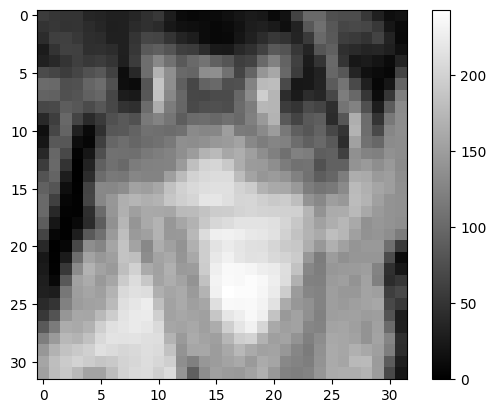

In [84]:
import matplotlib.pyplot as plt
import torch

# Assuming train_tensor[1][0] is your grayscale image tensor
image_tensor = train_tensor[1][0]

print(image_tensor.shape)

# Check if the tensor is on a CUDA device and move it to CPU
if image_tensor.is_cuda:
    image_tensor = image_tensor.cpu()

# Convert the tensor to a numpy array
image_numpy = image_tensor.numpy()

# Since it's grayscale, squeeze out the channel dimension if it exists
if image_tensor.dim() > 2:
    image_numpy = image_numpy.squeeze(0)

# Plot the image
plt.imshow(image_numpy, cmap='gray')
plt.colorbar()  # Optional, it adds a color bar to the side
plt.show()

In [85]:
image_tensor = train_tensor
image_labels = labels

Implemente el cálculo de las probabilidades a priori p (t)
para las K = 10 clases en el conjunto de datos de entrenamiento en
la función calcular_probabilidad_priori. Realice tal calculo dentro de la
funcion train_model.

In [86]:
import torch

"""
Calcula las probabilidades a priori de etiquetas únicas en un conjunto de datos.

Args:
    labels (list o torch.Tensor): Etiquetas para calcular las probabilidades.

Returns:
    tuple (torch.Tensor, torch.Tensor): Probabilidades de cada etiqueta y etiquetas únicas.
"""


def calculate_priori_p_t(labels):
    # Convertir labels a un tensor si aún no lo es
    labels_tensor = torch.tensor(labels) if not isinstance(
        labels, torch.Tensor) else labels

    # Contar las ocurrencias de cada etiqueta
    label_counts = labels_tensor.bincount()

    # Calcular probabilidades dividiendo por el número total de etiquetas
    probabilities = label_counts.float() / labels_tensor.size(0)

    # Generar un tensor de etiquetas únicas ordenadas
    unique_labels = torch.arange(label_counts.size(0))

    # Filtrar etiquetas con conteo cero
    nonzero_indices = label_counts.nonzero().squeeze()
    probabilities = probabilities[nonzero_indices]
    unique_labels = unique_labels[nonzero_indices]

    return probabilities, unique_labels


# Ejemplo de uso de la función
# Asegúrate de definir 'labels' antes de llamar a la función
probabilities, unique_labels = calculate_priori_p_t(image_labels)

print("Probabilities:", probabilities)
print("Unique labels:", unique_labels)
print("Sum of probabilities:", probabilities.sum())
print("Shape of probabilities:", probabilities.shape)

Probabilities: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
Unique labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Sum of probabilities: tensor(1.0000)
Shape of probabilities: torch.Size([10])


In [87]:
def calculate_marginal_probabilities(data, dim=0):
    # Calculate the marginal probabilities
    marginal_probabilities = data[dim].sum() / data.sum()
    return marginal_probabilities

In [88]:
Mock_data = torch.Tensor([[20.0, 70.0, 80.0, 10.0], [40.0, 10.0, 30.0, 5.0]])

print(calculate_marginal_probabilities(Mock_data, dim=0))
print(calculate_marginal_probabilities(Mock_data, dim=1))


tensor(0.6792)
tensor(0.3208)


In [89]:
def calculate_conditional_probabilities(data):
    # Calculate the conditional probabilities
    n_classes = data.shape[0]

    p_tensor = torch.zeros(data.shape)

    for i in range(n_classes):
        row_sum = data[i].sum()
        p_tensor[i] = data[i] / row_sum

    return p_tensor

p_tensor = calculate_conditional_probabilities(Mock_data)

print("Probabilities for class 0: ", p_tensor[0])
print("Probabilities for class 1: ", p_tensor[1])


Probabilities for class 0:  tensor([0.1111, 0.3889, 0.4444, 0.0556])
Probabilities for class 1:  tensor([0.4706, 0.1176, 0.3529, 0.0588])


In [90]:
import torch

"""
Calcula la matriz de probabilidad de las densidades de cada pixel para cada intensidad de pixel posible y para cada clase.

Args:
    images (torch.Tensor): Un tensor de imágenes con dimensiones [N, C, H, W], donde N es el número de imágenes, C es el número de canales, H es la altura y W es la anchura.
    normalize (bool, opcional): Si se debe normalizar la matriz de probabilidad tal que la suma de probabilidades de cada valor de pixel a través de todas las posiciones sea 1. Por defecto es False.

Returns:
    torch.Tensor: Un tensor de dimensiones [D, Z, K], donde D es el número de densidades (H*W), Z es el número máximo de intensidades de pixel posibles (255 máximo), y K es el número de clases. Cada columna corresponde a la densidad de cada pixel.
"""


def calculate_probability_matrix(images, normalize=False):
    min_pixel_value = int(images.min().item())
    max_pixel_value = int(images.max().item())
    num_pixel_values = max_pixel_value - \
        min_pixel_value + 1  # +1 because range is inclusive

    H, W = images.shape[2], images.shape[3]
    images_flattened = images.view(-1, H * W)

    # Create a range tensor of all possible pixel values
    range_tensor = torch.arange(
        min_pixel_value, max_pixel_value + 1, dtype=torch.float32, device=images.device)

    # Expand dimensions to allow broadcasting
    expanded_images = images_flattened.unsqueeze(2)  # Shape: [N*H*W, 1]
    expanded_range = range_tensor.unsqueeze(0).unsqueeze(
        0)  # Shape: [1, 1, num_pixel_values]

    # Use broadcasting to create a mask where each pixel value equals the range value
    mask = expanded_images == expanded_range

    # Sum over the first dimension to get histogram counts across all images and positions
    # Shape: [H*W, num_pixel_values]
    pixel_value_counts = mask.sum(dim=0, dtype=torch.float32)

    # Transpose to match the expected output shape
    # Shape: [num_pixel_values, H*W]
    pixel_value_counts = pixel_value_counts.t()

    probability_matrix = pixel_value_counts / images.shape[0]

    if normalize:
        # Normalize such that the sum of probabilities for each pixel value across all positions is 1
        probability_matrix = probability_matrix / \
            probability_matrix.sum(dim=1, keepdim=True)

    return probability_matrix.view(num_pixel_values, H, W)


def calculate_class_probabilities(train_data, labels, num_classes=3, normalize=False):
    class_probabilities = []

    for class_id in range(num_classes):
        class_indices = torch.where(labels == class_id)[0]
        class_images = train_data[class_indices]
        probability_matrix = calculate_probability_matrix(
            class_images, normalize=normalize)
        class_probabilities.append(probability_matrix)

    final_probability_tensor = torch.stack(class_probabilities, dim=0)
    return final_probability_tensor


# Ejemplo de uso
train_data = torch.randint(0, 256, (50000, 1, 32, 32), dtype=torch.uint8)
labels = torch.randint(0, 3, (50000,), dtype=torch.long)
final_probability_tensor = calculate_class_probabilities(
    train_data, labels, normalize=True)

print(final_probability_tensor.shape)  # Debería ser [3, 256, 32, 32]
print(final_probability_tensor)        # Este es tu tensor de resultado
# El resultado será 1 si la normalización se hace correctamente
# Ahora debería retornar correctamente 1
print(final_probability_tensor[0][0].sum())

torch.Size([3, 256, 32, 32])
tensor([[[[0.0009, 0.0011, 0.0010,  ..., 0.0011, 0.0011, 0.0007],
          [0.0008, 0.0009, 0.0010,  ..., 0.0010, 0.0009, 0.0011],
          [0.0009, 0.0010, 0.0009,  ..., 0.0008, 0.0008, 0.0011],
          ...,
          [0.0011, 0.0009, 0.0010,  ..., 0.0008, 0.0011, 0.0008],
          [0.0010, 0.0009, 0.0007,  ..., 0.0010, 0.0010, 0.0010],
          [0.0010, 0.0008, 0.0008,  ..., 0.0011, 0.0011, 0.0010]],

         [[0.0009, 0.0009, 0.0012,  ..., 0.0012, 0.0009, 0.0009],
          [0.0009, 0.0011, 0.0010,  ..., 0.0008, 0.0011, 0.0010],
          [0.0011, 0.0011, 0.0010,  ..., 0.0009, 0.0009, 0.0009],
          ...,
          [0.0010, 0.0008, 0.0009,  ..., 0.0010, 0.0010, 0.0010],
          [0.0012, 0.0010, 0.0011,  ..., 0.0009, 0.0008, 0.0011],
          [0.0010, 0.0011, 0.0010,  ..., 0.0012, 0.0009, 0.0010]],

         [[0.0009, 0.0010, 0.0010,  ..., 0.0010, 0.0009, 0.0012],
          [0.0011, 0.0010, 0.0009,  ..., 0.0009, 0.0009, 0.0010],
          [0.

In [91]:
def train_model_histogram(train_data, train_labels, normalize=True):
    priori_p_k, unique_labels = calculate_priori_p_t(train_labels)

    dataset_densities = calculate_class_probabilities(train_data, train_labels, num_classes=len(
        unique_labels), normalize=normalize)
    
    dataset_densities = torch.flatten(dataset_densities, start_dim=2, end_dim=3)


    return dataset_densities, priori_p_k


dataset_densities, priori_p_k = train_model_histogram(image_tensor, image_labels, normalize=False)

print(dataset_densities.shape)
print(dataset_densities[0][0].sum().item())

torch.Size([10, 256, 1024])
1.6040000915527344


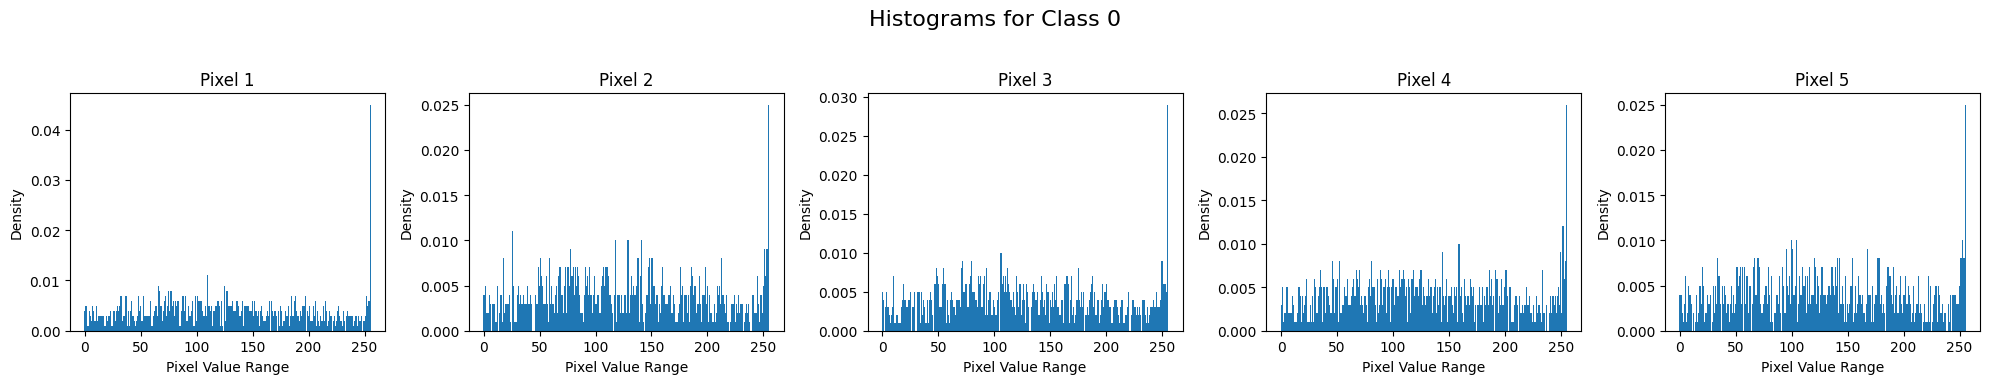

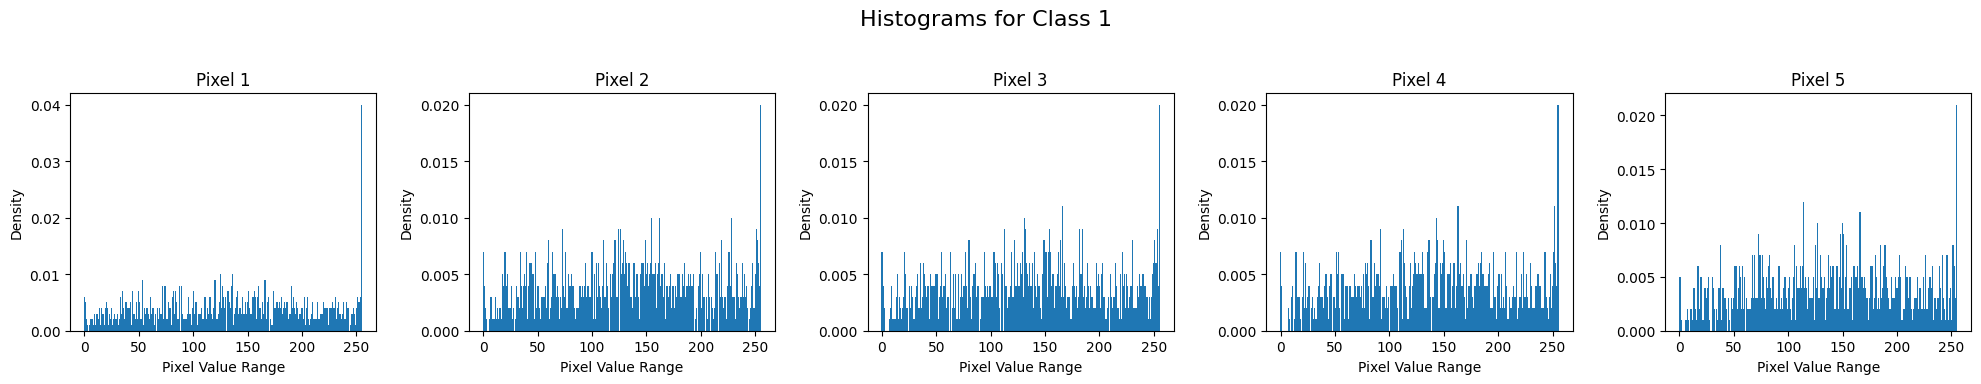

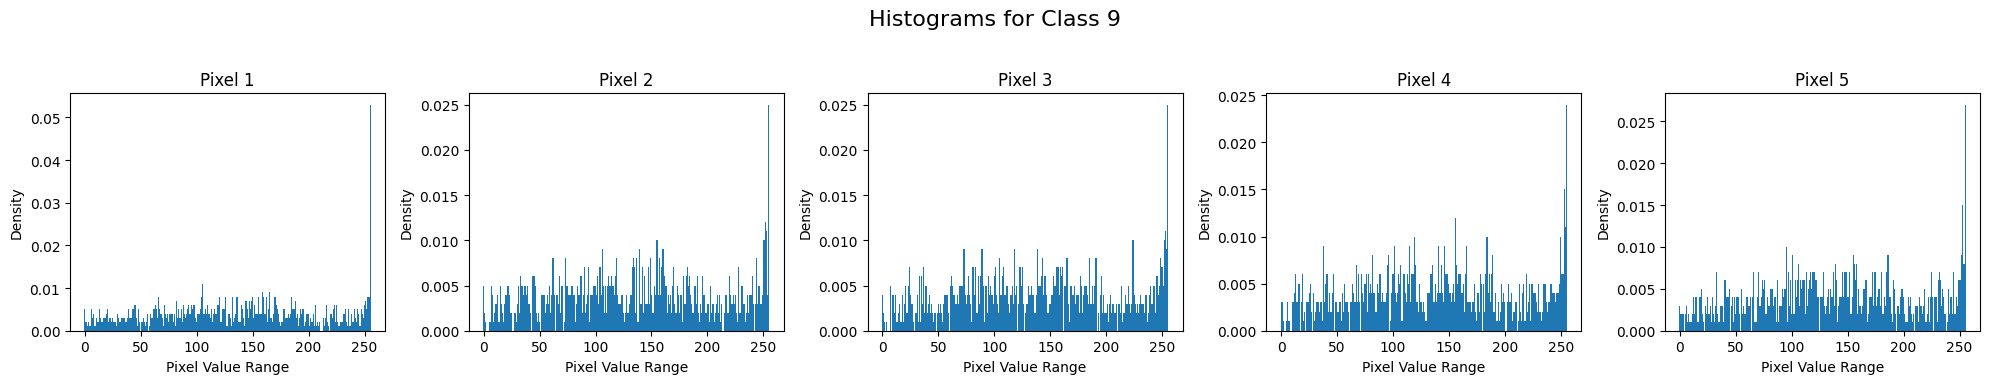

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Assuming you're using PyTorch tensors


def plot_pixel_densities(dataset_densities, class_index=0, num_pixels=5, bins=16):
    """
    Plots histograms for the specified number of pixels of a given class.

    Parameters:
    - dataset_densities: A tensor with shape [num_classes, 256, num_pixels].
    - class_index: The index of the class to plot the histograms for.
    - num_pixels: The number of pixels to plot histograms for.
    - bins: The number of bins to aggregate the pixel values into.
    """
    # Convert the tensor to a numpy array if it's a PyTorch tensor
    if isinstance(dataset_densities, torch.Tensor):
        dataset_densities = dataset_densities.numpy()

    # Extract the densities for the specified class
    class_densities = dataset_densities[class_index]

    # Calculate bin edges and widths for aggregation
    bin_edges = np.linspace(0, 256, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]

    # Plot histograms for the specified number of pixels
    fig, axs = plt.subplots(1, num_pixels, figsize=(20, 4))
    for i in range(num_pixels):
        pixel_densities = class_densities[:, i]
        # Aggregate pixel densities into bins
        binned_densities = np.histogram(
            np.arange(256), bins=bin_edges, weights=pixel_densities)[0]
        axs[i].bar(bin_edges[:-1], binned_densities, width=bin_width)
        axs[i].set_title(f'Pixel {i+1}')
        axs[i].set_xlabel('Pixel Value Range')
        axs[i].set_ylabel('Density')

    fig.suptitle(f'Histograms for Class {class_index}', fontsize=16)

    # Adjust layout to make room for the title
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Example usage
plot_pixel_densities(dataset_densities, class_index=0, num_pixels=5, bins=256)
plot_pixel_densities(dataset_densities, class_index=1, num_pixels=5, bins=256)
plot_pixel_densities(dataset_densities, class_index=9, num_pixels=5, bins=256)

In [96]:
def test_model_histogram(input_torch, dataset_densities, priori_p_k):
    # Calculate the log-likelihoods

    likelihoods = torch.zeros(dataset_densities.shape[0])
    num_pixel = 0

    for pixel in input_torch:
        pixel_value = int(pixel.item())


        for i in range(dataset_densities.shape[0]):
            likelihoods[i] += (dataset_densities[i][pixel_value][num_pixel] * priori_p_k[i])

        num_pixel += 1

    return likelihoods


image_tensor = train_tensor[77][0][0]

target = image_labels[77]
print(target)

pred = test_model_histogram(image_tensor, dataset_densities, priori_p_k)
pred

tensor(3)


tensor([0.0127, 0.0153, 0.0159, 0.0180, 0.0150, 0.0112, 0.0148, 0.0146, 0.0144,
        0.0147])